In [55]:
import random
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import statsmodels.stats.multitest as smt
from scipy.stats import t
from scipy import stats

In [79]:
def sample_gen( m1 , m2 , sigma1 , mean1 , sigma2 , mean2 ) :

    return np.random.normal(mean1, sigma1, m1) , np.random.normal(mean2, sigma2, m2)


def T(sample1 , sample2) :
    m1 = len(sample1) ; m2 = len(sample2)
    x1 = np.mean(sample1) ; x2 = np.mean(sample2)
    s = np.sqrt(  (np.sum((sample1 - x1)**2) + np.sum((sample2 - x2)**2 ))/(m1+m2-2) )
    return ( x1 - x2 ) / s / np.sqrt(1/m1 + 1/m2)

def p_value( sample1 , sample2) :
    return stats.ttest_ind(sample1, sample2, equal_var=True)[1]
    # value = np.abs(T(sample1,sample2)) 
    # return 2* (1 - t.cdf( value , len(sample1) + len(sample2) - 2)) 

def crit(sample1 , sample2 , alpha=0.05 )  : # соотв alpha = 0.05
   return stats.ttest_ind(sample1, sample2, equal_var=True)[1] < alpha


In [80]:
def get_p_values(m1 , m2 , n=100 ) :
    p_values = []
    sigma = [ 1 + j for j in range(n)] # Решили таким образом взять произвольными и разными для каждого признака
    for j in range(n-1) :
        sample1 ,sample2 = sample_gen(m1 , m2 , sigma[j] , 0 , sigma[j] , 0)
        p_values.append( p_value(sample1 , sample2 ))
    sample1 ,sample2 = sample_gen(m1 , m2 , sigma[n-1] , 0 , sigma[n-1] , 1) # Последня выборка (соотв последнему признаку ) с разными матожиданиями 
    p_values.append( p_value(sample1 , sample2 ))
    return np.array(p_values)    

#### Хотим $\alpha$ = 0.05 , а критерий используем - двухвыборочный Стьюента , потому посчитаем заранее $\alpha$/2 квантиль от распределения Стьюдента(m1 + m2 - 2)

Сгенерируем соответствующие выборки , получим их p_values и по каждому из признаков получим ответ - отклоняем гипотезу или нет

In [102]:
m1 = 50
m2 = 100
p_values = get_p_values(m1 ,m2 , 100)
reject_true_hypotesis = p_values[:-1] < 0.05
reject_false_hypotesis = p_values[-1:] < 0.05
print('Отклонить ложную гипотезу(принак с разностью матождианий 1)',reject_false_hypotesis)
print('Отклонить верную гипотезу: ',reject_true_hypotesis)
print('Число ложно отклоненных',np.sum(reject_true_hypotesis))

Отклонить ложную гипотезу(принак с разностью матождианий 1) [False]
Отклонить верную гипотезу:  [False False False False False False False False False False False False
 False False False False False False False  True  True False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False False False False False False
 False False False False False False  True  True False False False False
 False False False]
Число ложно отклоненных 7


Как видим число ложно отклоненных больше чем 0.05 * 99 ,с поправкой эта проблема пропадет , так же видим , что ложная гипотеза не отклоняется, потому что матожидания отличаются слабо (так как мощность криетрия мала)

#### С поправкой Бенджамини Хохберга (FDR)

In [82]:
N_sampling = 10000
value = 0
m1 = 50
m2 = 100
n = 100

for j in range(N_sampling) :

    p_values = get_p_values(m1 , m2 , n)

    p_values_1 = p_values[:-1] # Те что с равными матожиданиями (H_0) 
    p_values_2 = p_values[-1:]

    sorted_index = np.argsort(p_values)
    p_values = p_values[sorted_index]
    corrected_p_values = smt.multipletests( p_values, method='fdr_bh')[1]

    inverse_index = np.argsort(sorted_index)

    new_p_values_all = corrected_p_values[inverse_index]

    new_p_values_1 = new_p_values_all[:-1]
    new_p_values_2 = new_p_values_all[-1:]
    cnt_1 = np.sum( new_p_values_1 < 0.05 )
    cnt_2 = cnt_1 + np.sum( new_p_values_2 < 0.05)
    if cnt_2 != 0 :
        value += cnt_1/cnt_2
print( value/N_sampling) 

0.04865


Видим что поправка сработала

#### Исследуем ложно положительные и верно положительные отклонения (FDR)

In [124]:
N_sampling = 100

m1_arr = [10,50,100,200,300,400]
m2_arr = [10,50,100,200,300,400]
n = 100

results = np.zeros((len(m1_arr) , len(m2_arr)))
print(results.shape)

for i ,m1 in enumerate(m1_arr) :
    for j ,m2 in enumerate(m2_arr) :
        print(i,j)
        value = 0
        for _ in range(N_sampling) :
            p_values = get_p_values(m1 , m2 , n)

            p_values_1 = p_values[:-1] # Те что с равными матожиданиями (H_0) 
            p_values_2 = p_values[-1:]
            cnt_1 = np.sum( p_values_1 < 0.05 )
            cnt_2 = cnt_1 + np.sum( p_values_2 < 0.05)
            if cnt_2 != 0 :
                value += cnt_1/cnt_2
        results[i][j] = value / N_sampling



(6, 6)
0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5


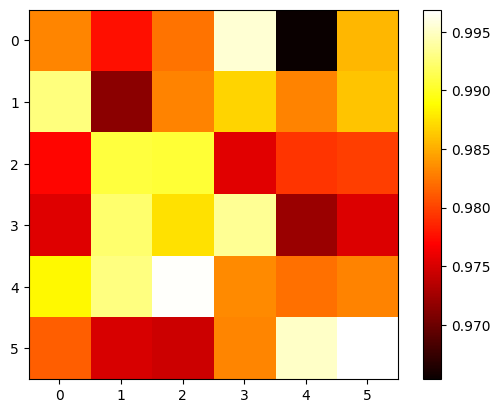

In [125]:
plt.imshow(results, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

FDR растет в зависимости от m1 и  m2 

#### С поправкой Бенджамини Хохберга

In [137]:
N_sampling = 100


m1_arr = [10,50,100,200,300,400,800]
m2_arr = [10,50,100,200,300,400,800]
n = 100

results_2 = np.zeros((len(m1_arr) , len(m2_arr)))
print(results_2.shape)

for i ,m1 in enumerate(m1_arr) :
    for j ,m2 in enumerate(m2_arr) :
        print(i,j)
        value = 0
        for _ in range(N_sampling) :
            p_values = get_p_values(m1 , m2 , n)

            sorted_index = np.argsort(p_values)
            p_values = p_values[sorted_index]
            corrected_p_values = smt.multipletests( p_values, method='fdr_bh')[1]

            inverse_index = np.argsort(sorted_index)

            new_p_values_all = corrected_p_values[inverse_index]

            new_p_values_1 = new_p_values_all[:-1]
            new_p_values_2 = new_p_values_all[-1:]
            cnt_1 = np.sum( new_p_values_1 < 0.05 )
            cnt_2 = cnt_1 + np.sum( new_p_values_2 < 0.05)
            if cnt_2 != 0 :
                value += cnt_1/cnt_2
        results_2[i][j] = value / N_sampling



(7, 7)
0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6


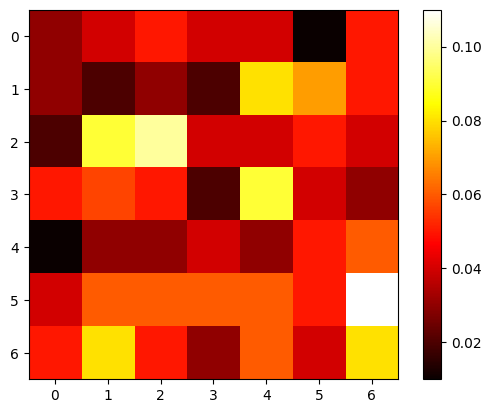

In [138]:
plt.imshow(results_2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

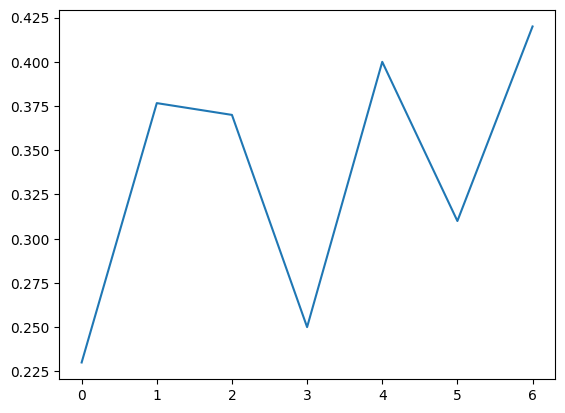

In [142]:
plt.plot(np.sum(results_2 , axis=0))

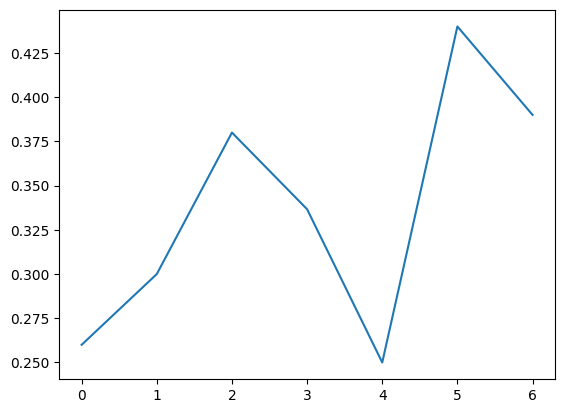

In [143]:
plt.plot(np.sum(results_2, axis=1))

#### Видна тенденция роста FDR при увеличении  m1  и m2 ,что соответствует теори, ведь растет мощность нашего критерия при росте m1 и m2